In [8]:
import pandas as pd, numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from scipy import sparse

In [3]:
use_rating_stats = False      # ⇦ cambia a False per togliere RatingAvg / RatingCount
random_state     = 0

In [4]:
df_raw = pd.read_csv('data/ratings_enriched.csv')
y      = df_raw['Rating'].astype(float).values

# SBERT embedding
sbert  = SentenceTransformer('all-MiniLM-L6-v2')
X_text = sparse.csr_matrix(
    sbert.encode(df_raw['Plot'].fillna('').tolist(),
                 batch_size=32, show_progress_bar=True, convert_to_numpy=True)
)

# generi multi‑hot
genre_lists = (df_raw[['Genre1','Genre2']].fillna('')
               .apply(lambda r: [g for g in r if g], axis=1)
               .tolist())
mlb       = MultiLabelBinarizer()
X_genres  = sparse.csr_matrix(mlb.fit_transform(genre_lists))

# feature numeriche
year_std  = ((df_raw['Year'].fillna(df_raw['Year'].mean()) - df_raw['Year'].mean())
             / df_raw['Year'].std()).values.reshape(-1,1)
num_parts = [year_std]
if use_rating_stats:
    rating_avg   = df_raw['RatingAvg'].fillna(df_raw['RatingAvg'].mean()).values.reshape(-1,1)
    rating_count = np.log1p(df_raw['RatingCount'].fillna(0)).values.reshape(-1,1)
    num_parts += [rating_avg, rating_count]
X_num = sparse.csr_matrix(np.hstack(num_parts))

Batches: 100%|██████████| 54/54 [00:11<00:00,  4.71it/s]


## LightGBM

In [15]:
# dizionari riga→feature
dir_dict = [{'dir='+d:1} for d in df_raw['Director1'].fillna('NA')]
cty_dict = [{'cty='+c:1} for c in df_raw['Country1'].fillna('NA')]

X_dir = FeatureHasher(n_features=256, input_type='dict', alternate_sign=False).transform(dir_dict)
X_cty = FeatureHasher(n_features=128, input_type='dict', alternate_sign=False).transform(cty_dict)
X_hash = sparse.hstack([X_dir, X_cty]).tocsr()

In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

X_all_lgb = sparse.hstack([X_text, X_genres, X_num, X_hash]).tocsr()
X_tr, X_te, y_tr, y_te = train_test_split(X_all_lgb, y,
                                          test_size=200/len(df_raw),
                                          random_state=random_state)

lgbm = LGBMRegressor(
    n_estimators=1200, learning_rate=0.04, num_leaves=128,
    min_child_samples=20, subsample=0.85, colsample_bytree=0.8,
    reg_lambda=1.0, random_state=random_state, verbose=-1
)
lgbm.fit(X_tr, y_tr)

pred = lgbm.predict(X_te)
print('LightGBM  MAE', round(mean_absolute_error(y_te, pred),3),
      'RMSE', round(root_mean_squared_error(y_te, pred),3))


LightGBM  MAE 0.36 RMSE 0.477


c:\Users\markh\Desktop\Codici\letterbot\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## CatBoost

In [9]:
from catboost import CatBoostRegressor, Pool

# concateniamo TUTTO (embedding + genres + numeriche) in un DataFrame
feat_names = [f'emb_{i}' for i in range(X_text.shape[1])] + \
             list(mlb.classes_) + ['year'] + \
             (['rating_avg','rating_count'] if use_rating_stats else [])
X_dense = pd.DataFrame(
    sparse.hstack([X_text, X_genres, X_num]).toarray(),
    columns=feat_names
)

# aggiungiamo le colonne categoriche grezze
X_dense['Director1'] = df_raw['Director1'].fillna('NA')
X_dense['Country1']  = df_raw['Country1'].fillna('NA')

cat_feats = ['Director1','Country1']

X_tr, X_te, y_tr, y_te = train_test_split(
    X_dense, y, test_size=200/len(df_raw), random_state=random_state
)

train_pool = Pool(X_tr, y_tr, cat_features=cat_feats)
test_pool  = Pool(X_te, y_te, cat_features=cat_feats)

cat = CatBoostRegressor(
    iterations=1000, learning_rate=0.01, depth=6,
    l2_leaf_reg=3, random_seed=random_state, verbose=False
)
cat.fit(train_pool)

pred = cat.predict(test_pool)
print('CatBoost  MAE', round(mean_absolute_error(y_te, pred),3),
      'RMSE', round(root_mean_squared_error(y_te, pred),3))

CatBoost  MAE 0.495 RMSE 0.655


In [19]:
df_test = df_raw.loc[X_te.index, :]
df_test['Pred'] = pred

<Axes: ylabel='Frequency'>

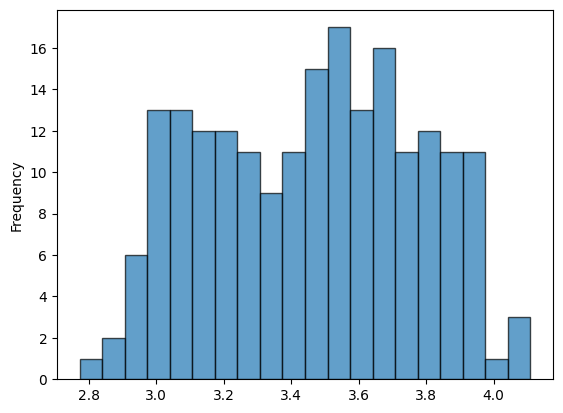

In [20]:
df_test['Pred'].plot.hist(bins=20, edgecolor='black', alpha=0.7)

In [ ]:
cat.save_model('models/catboost_ratings.cbm')
lgbm.booster_.save_model('models/lightgbm_ratings.txt')